继续手腕疼, 无心工作. 

于是写了一个自由曲面的描述, 求了曲面上每点的法向量, 写了已知入射点时照射到该自由曲面上的反射和折射过程. 
还用pytorch写的.

当然这样做什么用处. 但可以排解手腕疼的不适感. 
<!-- TEASER_END -->

# 建立一个自由曲面

* 建立一个自由曲面
* 可以放置在空间中的不同位置
* 自由曲面上任意一点求得法线和切面

# 导入必要的库

In [1]:
import numpy as np
try:
    import torch
    from torch.autograd import Variable
except: 
    !conda install pytorch --yes
    import torch
    from torch.autograd import Variable
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
% matplotlib inline


# 自由曲面表示

## Chebyshev polynomial coefficients

The Chebyshev polynomial of the first kind is given by formula:
$$
Tn (x) = cos(n cos^{-1}(x)) , n=0..∞, x∈[-1,1]
$$

The first ten Chebyshev polynomial coefficients are the following:

$$
T0 (x) = 1\\
T1 (x) = x\\
T2 (x) = 2x^2 - 1\\
T3 (x) = 4x^3 - 3x\\
T4 (x) = 8x^4 - 8x^2 + 1\\
T5 (x) = 16x^5- 20x^3 + 5x\\
T6 (x) = 32x^6 - 48x^4 + 18x^2 - 1\\
T7 (x) = 64x^7 - 112x^5 + 56x^3 - 7x\\
T8 (x) = 128x^8 - 256x^6 + 160x^4 - 32x^2 + 1\\
T9 (x) = 256x^9 - 576x^7 + 432x^5 - 120x^3 + 9x\\
T10 (x) = 512x^{10} - 1280x^8 + 1120x^6 - 400x^4 + 50x^2 - 1\\
$$

In [2]:
def T(n,x):
    ans=torch.cos(n* torch.acos(x))
    return ans

In [3]:
if __name__=="__main__":
    n=6
    dtype = torch.FloatTensor
    x = Variable(torch.Tensor([0.1,0.2]).type(torch.FloatTensor), requires_grad=False)    
    print(T(n,x))
    print(32*x**6-48*x**4+18*x**2-1)

Variable containing:
-0.8248
-0.3548
[torch.FloatTensor of size 2]

Variable containing:
-0.8248
-0.3548
[torch.FloatTensor of size 2]



## 自由曲面
$$
z=\frac{c\left( x^{2}+y^{2} \right)}{1+\sqrt{1-c^{2}\left( x^{2}+y^{2} \right)}}+\sum_{i=0}^{N}{\sum_{j=0}^{M}{a_{ij}\cdot T_{i}\left( x \right)T_{j}\left( y \right)}}
$$

In [4]:
def surface(c,a,x,y):
    r2=x**2+y**2
    p1=c*r2/(1+torch.sqrt(1-c**2*r2))
    N,M=a.size()
    s=0
    for i in range(0,N):
        for j in range(0, M):
            s = s + a[i,j]*T(i,x)*T(j,y)
    z=p1+s
    return z

In [5]:
if __name__=="__main__":
    a= Variable(torch.randn(2,3).type(dtype), requires_grad=False) 
    print(a.size())
    c=1
    x = Variable(torch.Tensor([0.1,0.2]).type(dtype), requires_grad=False) 
    y = Variable(torch.Tensor([0.1,0.2]).type(dtype), requires_grad=False)    
    print(surface(c,a,x,y))

torch.Size([2, 3])
Variable containing:
 1.9250
 1.9734
[torch.FloatTensor of size 2]



## 绘制曲面图


In [6]:
def draw_surface(X,Y,Z):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
#     print(X.data.numpy())
    ax.plot_surface(X.data.numpy(), Y.data.numpy(), Z.data.numpy(), color='b',alpha=0.3)
    plt.show()
def draw_freeform(c,a):
    x = np.linspace(-1,1,50)
    y = np.linspace(-1,1,50)
    xv, yv = np.meshgrid(x, y)
    xv=Variable(torch.Tensor(xv).type(torch.FloatTensor), requires_grad=False) 
    yv=Variable(torch.Tensor(yv).type(torch.FloatTensor), requires_grad=False) 
    z=surface(c,a,xv,yv)
    draw_surface(xv,yv,z)

/Users/goldengrape/anaconda3/envs/blog/lib/python3.5/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


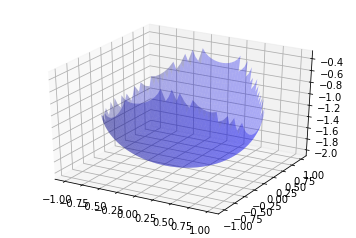

In [198]:
if __name__=="__main__":
    c=1
    a= Variable(torch.randn(2,3).type(torch.FloatTensor), requires_grad=False) 
    draw_freeform(c,a); 

# 求法向量

已知有曲面
$$
z=f(x,y)
$$
则曲面在(x0,y0,z0)位置的法向量: 
$$
\left[ 
\begin{array}{c} 
\frac{\partial }{\partial x}f\left( x,y \right) |_{x=x0} \\ 
\frac{\partial }{\partial y}f\left( x,y \right) |_{y=y0} \\ 
-1 
\end{array} 
\right]
$$

已知:

$$
z=\frac{c\left( x^{2}+y^{2} \right)}{1+\sqrt{1-c^{2}\left( x^{2}+y^{2} \right)}}+\sum_{i=0}^{N}{\sum_{j=0}^{M}{a_{ij}\cdot T_{i}\left( x \right)T_{j}\left( y \right)}}
$$

分别求导: 

$$
\partial \frac{(\frac{c\left( x^{2}+y^{2} \right)}{1+\sqrt{1-c^{2}\left( x^{2}+y^{2} \right)}})}
{\partial x}=
\frac{(c^3 x (x^2 + y^2))}{(\sqrt{1 - c^2 (x^2 + y^2)} (1 + \sqrt{1 - c^2 (x^2 + y^2)})^2) + (2 c x)/(1 + \sqrt{1 - c^2 (x^2 + y^2)})}
$$

对Chebyshev polynomial求导: 

$$
\partial \frac{\sum_{i=0}^{N}{\sum_{j=0}^{M}{a_{ij}\cdot T_{i}\left( x \right)T_{j}\left( y \right)}}}{\partial x}=
\sum_{i=0}^{N}{\sum_{j=0}^{M}{a_{ij}\cdot iU_{i-1}\left( x \right)T_{j}\left( y \right)}}
$$

其中: 

$$
n U_{n-1}(x)=\frac{n sin(n cos^{-1}(x))}{\sqrt{1-x^2}}
$$

In [8]:
def dT(n,x):
    ans=n*(torch.sin(n* torch.acos(x)))/(torch.sqrt(1-x**2))
    return ans

In [13]:
def dPart1(c,x,y):
    ans=(c**3*x*(x**2+y**2))/(torch.sqrt(1-c**2*(x**2+y**2))*(1+torch.sqrt(1-c**2*(x**2+y**2)))**2)+(2*c*x)/(1+torch.sqrt(1-c**2*(x**2+y**2)))
    return ans

In [97]:
def norm_vec(c,a,x,y):
    # dz/dx
    dPart1_dx=dPart1(c,x,y)
    dPart1_dy=dPart1(c,y,x)
    N,M=a.size()
    ds_dx=0
    ds_dy=0
    for i in range(0,N):
        for j in range(0, M):
            ds_dx= ds_dx + a[i,j]*dT(i,x)*T(j,y)
            ds_dy= ds_dy + a[i,j]*T(i,x)*dT(j,y)
    dz_dx=dPart1_dx+ds_dx
    dz_dy=dPart1_dy+ds_dy
    nv=Variable(-1*torch.ones(list(x.size())[0],3).type(torch.FloatTensor))
    nv[:,0]=dz_dx
    nv[:,1]=dz_dy
    nv=nv/nv.norm(dim=1,keepdim=True) # normalize vector
    return nv


In [188]:
if __name__=="__main__":
    a=0*Variable(torch.ones(3,3).type(dtype), requires_grad=True) 
    c=1
    x = Variable(torch.Tensor([0,0.1,0.2,0.5]).type(torch.FloatTensor), requires_grad=True) 
    y = Variable(torch.Tensor([0.1,0,0.2,0.5]).type(torch.FloatTensor), requires_grad=True)

    print(norm_vec(c,a,x,y))

    

Variable containing:
 0.0000  0.1000 -0.9950
 0.1000  0.0000 -0.9950
 0.2000  0.2000 -0.9592
 0.5000  0.5000 -0.7071
[torch.FloatTensor of size 4x3]



# 折射与反射
参考 https://en.wikipedia.org/wiki/Snell's_law 中的矢量形式

* 入射光方向: $\vec l$
* 曲面的法向量: $\vec n$
* 入射面介质折射率: $n_1$
* 出射面介质折射率: $n_2$
* $ r=n_1/n_2$
* $ c=-\vec n \cdot \vec l $

$$
V_{reflect}=\vec l + 2 c \vec n\\
V_{refract}=r\vec l+(rc-\sqrt{1-r^2(1-c^2)})\vec n
$$

In [180]:
def V_reflect(vec_l,vec_n,n1,n2):
    r=n1/n2
    if len(vec_l.size())>1:
        c=torch.diag(-torch.mm(vec_n,torch.transpose(vec_l,0,1)),diagonal=0).view(-1,1)
    else:
        c=-torch.mm(vec_n.view(1,-1),vec_l.view(-1,1))
    V=vec_l+2*c*vec_n
    return V/V.norm(dim=1,keepdim=True)
def V_refract(vec_l,vec_n,n1,n2):
    r=n1/n2
    if len(vec_l.size())>1:
        c=torch.diag(-torch.mm(vec_n,torch.transpose(vec_l,0,1)),diagonal=0).view(-1,1)
    else:
        c=-torch.mm(vec_n.view(1,-1),vec_l.view(-1,1))
    V=r*vec_l+(r*c-torch.sqrt(1-r**2*(1-c**2)))*vec_n
    return V/V.norm(dim=1,keepdim=True)

In [186]:
if __name__=="__main__":
#     vec_l=Variable(torch.Tensor([0.707107, -0.707107]).type(dtype), requires_grad=True) 
#     vec_n=Variable(torch.Tensor([0,1]))
    vec_l=Variable(torch.randn(5,3).type(torch.FloatTensor), requires_grad=True) 
    vec_n=Variable(torch.randn(5,3))
    n1=0.9
    n2=1
    print(V_reflect(vec_l,vec_n,n1,n2))
    print(V_refract(vec_l,vec_n,n1,n2))

Variable containing:
 0.8951  0.4025 -0.1919
-0.8368  0.1482 -0.5271
 0.1819  0.6201  0.7632
-0.8726  0.4421 -0.2076
 0.8111 -0.4376  0.3882
[torch.FloatTensor of size 5x3]

Variable containing:
 0.8872  0.3847 -0.2549
-0.8791 -0.1163 -0.4621
-0.1896  0.9623  0.1952
-0.8725  0.4422 -0.2079
 0.5162  0.6266  0.5838
[torch.FloatTensor of size 5x3]



# 自由曲面上的折射与反射
* 已知自由曲面上一点(x_f,y_f,z_f)
* 已知入射光上一点(x0,y0,z0)
* 求反射光和折射光方向

In [196]:
def get_vec_l(c,a,xf,yf,x0,y0,z0):
    zf=surface(c,a,xf,yf)
    vec_l=Variable(-1*torch.zeros(list(xf.size())[0],3).type(torch.FloatTensor))
    vec_l[:,0]=xf-x0
    vec_l[:,1]=yf-y0
    vec_l[:,2]=zf-z0
    return vec_l

def reflect_on_surface(c,a,xf,yf,x0,y0,z0,n1,n2):
    vec_l=get_vec_l(c,a,xf,yf,x0,y0,z0)
    vec_n=norm_vec(c,a,x,y)
    return V_reflect(vec_l,vec_n,n1,n2)

def refract_on_surface(c,a,xf,yf,x0,y0,z0,n1,n2):
    vec_l=get_vec_l(c,a,xf,yf,x0,y0,z0)
    vec_n=norm_vec(c,a,x,y)
    return V_refract(vec_l,vec_n,n1,n2)

In [197]:
if __name__=="__main__":
    a=0*Variable(torch.ones(3,3).type(dtype), requires_grad=True) 
    c=1
    xf = Variable(torch.Tensor([0  ,0.1,0.2,0.5]).type(torch.FloatTensor), requires_grad=True) 
    yf = Variable(torch.Tensor([0.1,0  ,0.2,0.5]).type(torch.FloatTensor), requires_grad=True)
    x0 = Variable(torch.Tensor([0]).type(torch.FloatTensor), requires_grad=True) 
    y0 = Variable(torch.Tensor([0]).type(torch.FloatTensor), requires_grad=True) 
    z0 = Variable(torch.Tensor([-1]).type(torch.FloatTensor), requires_grad=True) 
        
    n1=1
    n2=1.5
    print(reflect_on_surface(c,a,xf,yf,x0,y0,z0,n1,n2))
    print(refract_on_surface(c,a,xf,yf,x0,y0,z0,n1,n2))

Variable containing:
 0.0000  0.2951 -0.9555
 0.2951  0.0000 -0.9555
 0.5260  0.5260 -0.6683
 0.6204  0.6204  0.4798
[torch.FloatTensor of size 4x3]

Variable containing:
 0.0000  0.0330  0.9995
 0.0330  0.0000  0.9995
 0.0607  0.0607  0.9963
 0.0600  0.0600  0.9964
[torch.FloatTensor of size 4x3]



# 然而并没有什么用

到目前为止, 即使上述的运算都对, 也没有什么实际用途. 因为如果要做光路追迹, 要从一个点发射光线, 打中自由曲面, 然后折射或者反射. 求解光线击中自由曲面的位置, 好像只能迭代求解了. 
